In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append(os.path.realpath('..'))

In [15]:
import numpy as np
import scipy as sp
import pandas as pd
import plotly.express as ex
from copy import deepcopy

from tracking_v2.target import SingleTurnTarget
from tracking_v2.kalman import LinearKalmanFilter, CoordinatedTurn, CoordinatedTurn2D
from tracking_v2.motion import ConstantVelocityModel
from tracking_v2.sensor import GeometricSensor
from tracking.util import to_df

In [5]:
def run_one(n, target, sensor, kf):
    T = 1
    t = 0
    
    positions = target.true_states(T, n+1)[:, :3]
    
    m = sensor.generate_measurement(t, positions[0, :])
    kf.initialize(m.z, m.R)

    x_hat, P_hat = [], []
    for position in positions[1:, :]:
        t += T
        
        kf.predict(T)

        x_hat.append(kf.x_hat)
        P_hat.append(kf.P_hat)

        m = sensor.generate_measurement(t, position)
        kf.update(m.z, m.R)

    x_hat, P_hat = np.array(x_hat), np.array(P_hat)
    
    assert x_hat.shape[0] == n
    assert P_hat.shape[0] == n
    
    return x_hat, P_hat

def run_mc(m, n, target, sensor, kf, seeds=None):
    if seeds is None:
        seeds = np.arange(m)
    
    x_hat, P_hat = [], []
    for seed in seeds:
        kf = deepcopy(kf)
        x, P = run_one(n, target, sensor, kf)
        x_hat.append(x)
        P_hat.append(P)
    
    x_hat, P_hat = np.array(x_hat), np.array(P_hat)

    assert x_hat.shape[0] == m
    assert P_hat.shape[0] == m
    
    return x_hat, P_hat

In [24]:
target = SingleTurnTarget()
sensor = GeometricSensor()

kf = LinearKalmanFilter(ConstantVelocityModel(), [[1, 0, 0, 0, 0, 0],
                                                  [0, 1, 0, 0, 0, 0],
                                                  [0, 0, 1, 0, 0, 0]])

x_hat, P_hat = run_mc(100, 400, target, sensor, kf)

In [25]:
x_hat.shape

(100, 400, 6, 1)

In [133]:
target = SingleTurnTarget(30, 1)
positions = target.true_states(1, 400+1)[:, :3]

sensor = GeometricSensor()

kf = CoordinatedTurn([1, 1, 1, .02])

x_hat, P_hat = run_one(400, target, sensor, kf)

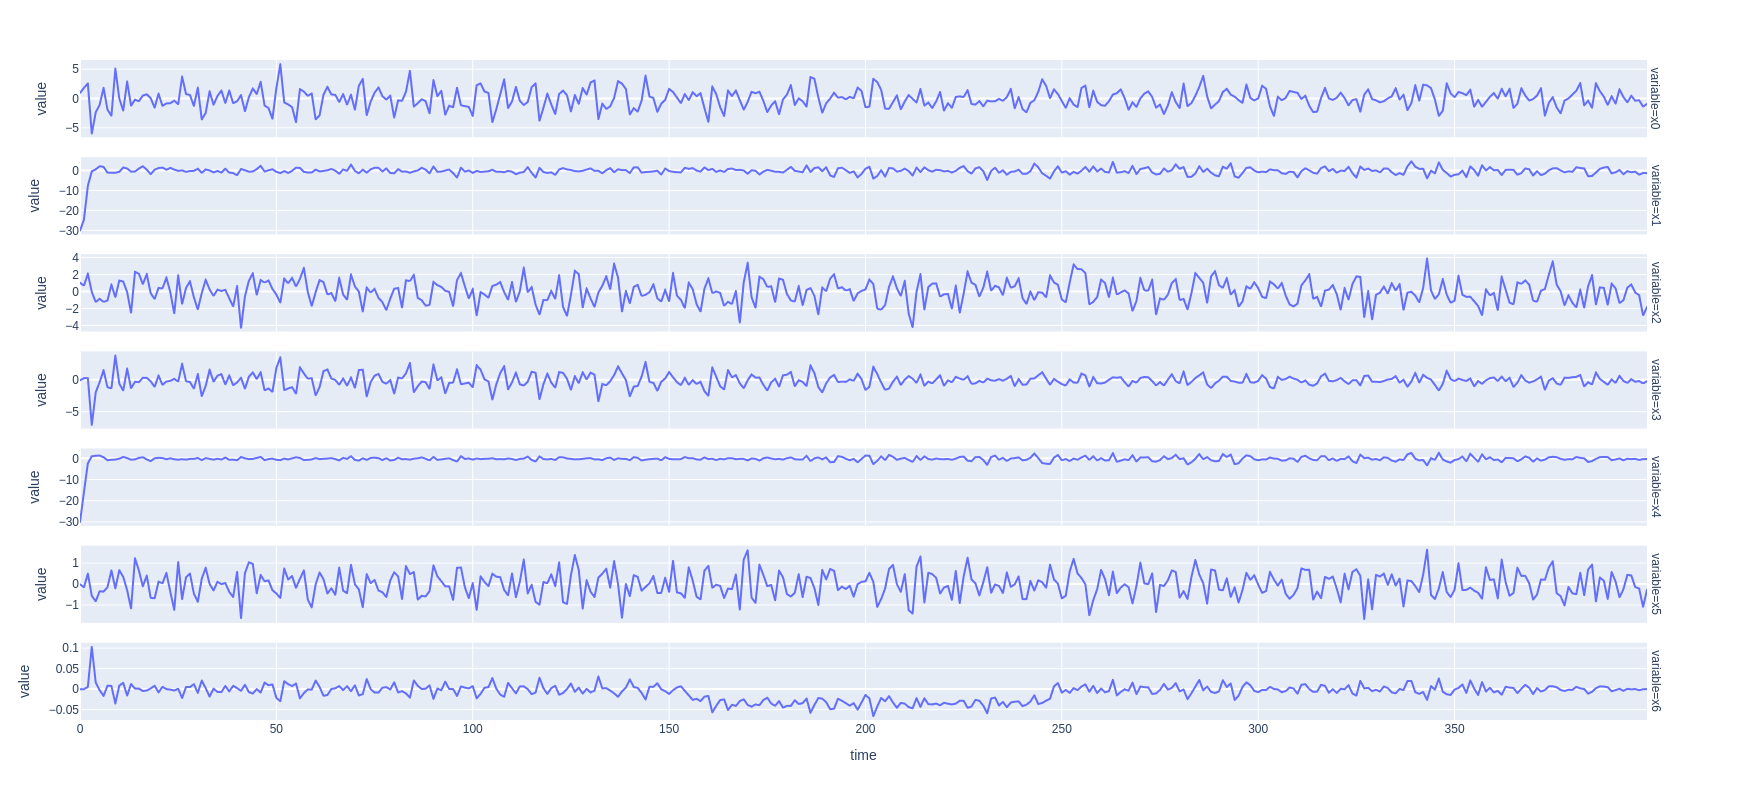

In [143]:
full_states = np.hstack((target.true_states(1, 400+1)[1:, :], np.diff(target.heading(1, 401)).reshape(400, -1)))
df = to_df(x_hat.squeeze() - full_states)
df['time'] = np.arange(400)

fig = ex.line(df.melt(['time'], ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']), x='time', y='value', facet_row='variable')
fig.update_yaxes(matches=None)
fig.update_layout(height=800)
fig

In [104]:
kf1 = CoordinatedTurn([1, 1, 1, .02])
kf2 = CoordinatedTurn2D([[1, 0, 0, 0, 0],
                         [0, 0, 1, 0, 0]],
                        [1,.02])

with np.printoptions(precision=2):
    print(kf1.x_hat.T)
    print(kf2.x_hat.T)
    print()
    print(kf1.P_hat)
    print()
    print(kf2.P_hat)

print()

m = sensor.generate_measurement(0, positions[0, :])
kf.initialize(m.z, m.R)

t = 0

with np.printoptions(precision=2):
    print(kf1.x_hat.T)
    print(kf2.x_hat.T)
    print()
    print(kf1.P_hat)
    print()
    print(kf2.P_hat)

[[0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]]

[[1.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.02]]

[[1.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.  ]
 [0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.02]]

[[0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]]

[[1.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.02]]

[[1.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.  ]
 [0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.02]]


In [99]:
for _ in range(200):
    t += 1
    kf.predict(1)
    m = sensor.generate_measurement(t, positions[t, :])
    kf.update(m.z, m.R)

In [105]:
t += 1
kf1.predict(1)
kf2.predict(1)

print(t)

with np.printoptions(precision=2):
    print(kf1.x_hat.T)
    print(kf2.x_hat.T)
    print()
    print(kf1.P_hat)
    print()
    print(kf2.P_hat)
    print("\nf\n")
    print(kf1.f(1))
    print(kf2.f(1))
    print("\nf_x\n")
    print(kf1.f_x(1))
    print(kf2.f_x(1))
    print("\nQ\n")
    print(kf1.Q(1))
    print(kf2.Q(1))

m = sensor.generate_measurement(t, positions[t, :])
kf1.update(m.z, m.R)
kf2.update(m.z[:, :2], m.R[:2, :2])

print()

with np.printoptions(precision=2):
    print(kf1.x_hat.T)
    print(kf2.x_hat.T)
    print()
    print(kf1.P_hat)
    print()
    print(kf2.P_hat)

1
[[0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]]

[[2.25 0.   0.   1.5  0.   0.   0.  ]
 [0.   2.25 0.   0.   1.5  0.   0.  ]
 [0.   0.   2.25 0.   0.   1.5  0.  ]
 [1.5  0.   0.   2.   0.   0.   0.  ]
 [0.   1.5  0.   0.   2.   0.   0.  ]
 [0.   0.   1.5  0.   0.   2.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.04]]

[[2.25 1.5  0.   0.   0.  ]
 [1.5  2.   0.   0.   0.  ]
 [0.   0.   2.25 1.5  0.  ]
 [0.   0.   1.5  2.   0.  ]
 [0.   0.   0.   0.   0.02]]

f

[[1 0 0 1 0 0 0]
 [0 1 0 0 1 0 0]
 [0 0 1 0 0 1 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]]
[[1 1 0 0 0]
 [0 1 0 0 0]
 [0 0 1 1 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]

f_x

[[ 1.  0.  0.  1.  0.  0. -0.]
 [ 0.  1.  0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.  0. -0.]
 [ 0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.]]
[[ 1.  1.  0.  0. -0.]
 [ 0.  1.  0.  0. -0.]
 [ 0.  0.  1.  1.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]]

Q

[[0.25 0. 

In [106]:
kf1.Q(1)

array([[0.25, 0.  , 0.  , 0.5 , 0.  , 0.  , 0.  ],
       [0.  , 0.25, 0.  , 0.  , 0.5 , 0.  , 0.  ],
       [0.  , 0.  , 0.25, 0.  , 0.  , 0.5 , 0.  ],
       [0.5 , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.5 , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.5 , 0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02]])

In [113]:
dt = 1
T = dt
T2 = dt*dt
Gamma_CT = np.array([[T2/2, 0,    0,    0],
                     [0,    T2/2, 0,    0],
                     [0,    0,    T2/2, 0],
                     [T,    0,    0,    0],
                     [0,    T,    0,    0],
                     [0,    0,    T,    0],
                     [0,    0,    0,    T]])

Gamma_CT @ kf1.Q_base @ Gamma_CT.T

array([[0.25, 0.  , 0.  , 0.5 , 0.  , 0.  , 0.  ],
       [0.  , 0.25, 0.  , 0.  , 0.5 , 0.  , 0.  ],
       [0.  , 0.  , 0.25, 0.  , 0.  , 0.5 , 0.  ],
       [0.5 , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.5 , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.5 , 0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02]])

In [114]:
Gamma_CT.T

array([[0.5, 0. , 0. , 1. , 0. , 0. , 0. ],
       [0. , 0.5, 0. , 0. , 1. , 0. , 0. ],
       [0. , 0. , 0.5, 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 1. ]])

In [112]:
kf1.Q_base @ kf1.Q_base.T

array([[1.e+00, 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 1.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 1.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 4.e-04]])

In [12]:
target = SingleTurnTarget(30, 1)
sensor = GeometricSensor(seed=0)
true_positions = target.true_states()

mc_runs = 200
mc_nees_scores = []

for _ in range(mc_runs):
    ct = CoordinatedTurn([1, 1, 1, .02289])
    t = 0
    ct.initialize(true_positions[t, :3], np.eye(3))

    x_hat, P_hat = [], []
    for _ in range(399):
        t += 1
        m = sensor.generate_measurement(t, true_positions[t, :3])

        ct.predict(1)
        ct.update(m.z, m.R)

        x_hat.append(np.copy(ct.x_hat))
        P_hat.append(np.copy(ct.P_hat))

    x_hat, P_hat = np.array(x_hat), np.array(P_hat)

    # select only positions
    x_hat = x_hat[:, :3, :]
    P_hat = P_hat[:, :3, :3]

    d = x_hat.squeeze() - true_positions[1:, :3]
    d = d.reshape(399, 3, 1)
    P_inv = np.linalg.inv(P_hat)
        
    mc_run_scores = np.matmul(np.matmul(d.transpose(0, 2, 1), P_inv), d).squeeze()
    mc_nees_scores.append(mc_run_scores)

mc_nees_scores = np.array(mc_nees_scores).T
mc_nees_scores = np.mean(mc_nees_scores, axis=1)


In [16]:
    state_dim = 3
    conf_int = sp.stats.chi2.ppf([0.025, 0.975], mc_runs * state_dim) / mc_runs


In [10]:
np.array(x_hat).shape

(399, 7, 1)

In [17]:
conf_int

array([2.67009275, 3.34884576])

In [19]:
within_conf_int = np.logical_and(conf_int[0] <= mc_nees_scores, mc_nees_scores <= conf_int[1])

In [23]:
within_conf_int[15:].mean()

0.6796875